# Indexing

Selecting subsets of data.

This is subset of the data from beeradvocate.com, via [Standford](https://snap.stanford.edu/data/web-RateBeer.html). It's strangely formatted.

```
beer/name: Sausa Weizen
beer/beerId: 47986
beer/brewerId: 10325
beer/ABV: 5.00
beer/style: Hefeweizen
review/appearance: 2.5
review/aroma: 2
review/palate: 1.5
review/taste: 1.5
review/overall: 1.5
review/time: 1234817823
review/profileName: stcules
review/text: A lot of foam. But a lot.	In the smell some banana, and then lactic and tart. Not a good start.	Quite dark orange in color, with a lively carbonation (now visible, under the foam).	Again tending to lactic sourness.	Same for the taste. With some yeast and banana.		

beer/name: Red Moon
beer/beerId: 48213
beer/brewerId: 10325
beer/ABV: 6.20
 ...
```

The dataset was a bit large to processess all at once

```bash
$ wc -l beeradvocate.txt
 22212596 beeradvocate.txt
```

So I parsed them in chunks.

```python
def format_review(review):
    return dict(map(lambda x: x.strip().split(": ", 1), review))

def as_dataframe(reviews):
    col_names = {
        'beer/ABV': 'abv', 'beer/beerId': 'beer_id', 'beer/brewerId': 'brewer_id',
        'beer/name': 'beer_name', 'beer/style': 'beer_style',
        'review/appearance': 'review_appearance', 'review/aroma': 'review_aroma',
        'review/overall': 'review_overall', 'review/palate': 'review_palate',
        'review/profileName': 'profile_name', 'review/taste': 'review_taste',
        'review/text': 'text', 'review/time': 'time'
    }
    df = pd.DataFrame(list(reviews))
    numeric = ['abv', 'review_appearance', 'review_aroma',
               'review_overall', 'review_palate', 'review_taste']
    df = (df.rename(columns=col_names)
            .replace('', np.nan))
    df[numeric] = df[numeric].astype(float)
    df['time'] = pd.to_datetime(df.time.astype(int), unit='s')
    return df

def main():
    with open('beeradvocate.txt') as f:
        reviews = filter(lambda x: x != ('\n',),
                         partitionby(lambda x: x == '\n', f))
        reviews = map(format_review, reviews)
        reviews = partition(100000, reviews, pad=None)
        reviews = filter(None, reviews)
        os.makedirs('beer_reviews', exist_ok=True)

        for i, subset in enumerate(reviews):
            print(i, end='\r')
            df = as_dataframe(subset)
            df.to_csv('beer_reviews/review_%s.csv' % i, index=False)
```

# Aside: dask

To select the subset we'll work with, about a 10th of the reviews, I used [`dask`](http://dask.readthedocs.org).
All of those files wouldn't fit in memory at once. But we can compute quantiles in chunks and aggregate those together. 

```python

In [1]: import dask.dataframe as dd

In [2]: df = dd.read_csv('beer_reviews/*.csv', parse_dates=['time'])

In [3]: cutoffs = df.time.quantiles([.5, .6])

In [4]: %time cutoffs = cutoffs.compute()
CPU times: user 20.7 s, sys: 8.37 s, total: 29.1 s
Wall time: 28.2 s

In [5]: %time subset = df[(df.time >= cutoffs[0]) & (df.time <= cutoffs[1])].compute()
CPU times: user 20.9 s, sys: 7.68 s, total: 28.6 s
Wall time: 27.5 s

In [6]: subset.to_csv('../notebooks/data/beer_subset.csv', index=False)
```

Just wirting `cutoff = df.time.quantile([10])` doesn't actually do the computation, instead it build of dask graph of what it needs to do when asked for the result. If that sounds interesting consider going to Matthew Rocklin's [dask tutorial](https://github.com/ContinuumIO/dask-tutorial/) during the next session.

Here's the graph for the percentile to calculate `cutoff`

In [1]:
from IPython import display

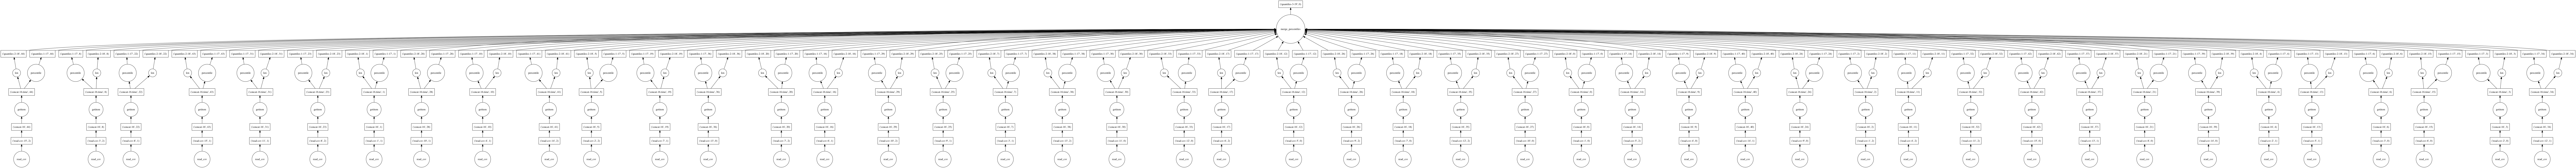

In [2]:
display.Image('cutoffs.png')

And the graph for `subset`

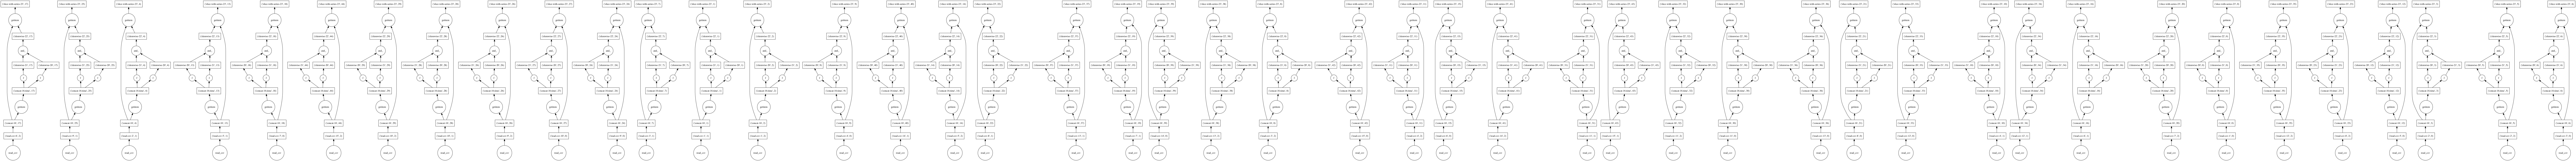

In [3]:
display.Image('subset.png')

`subset` fits comfortably in memory, so we can sort it and write it out to csv. That's what we'll work with for this notebook.

In [2]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10

In [3]:
df = pd.read_csv('data/beer_subset.csv.gz', parse_dates=['time'], compression='gzip')
review_cols = ['review_appearance', 'review_aroma', 'review_overall',
               'review_palate', 'review_taste']
df.head()

abv  beer_id  brewer_id                            beer_name  \
0  7.0     2511        287                  Bell's Cherry Stout   
1  5.7    19736       9790                   Duck-Rabbit Porter   
2  4.8    11098       3182         Fürstenberg Premium Pilsener   
3  9.5    28577       3818  Unearthly (Imperial India Pale Ale)   
4  5.8      398        119                   Wolaver's Pale Ale   

                       beer_style  review_appearance  review_aroma  \
0                  American Stout                4.5             4   
1                 American Porter                4.5             4   
2                 German Pilsener                4.0             3   
3  American Double / Imperial IPA                4.0             4   
4         American Pale Ale (APA)                4.0             3   

   review_overall  review_palate profile_name  review_taste  \
0             4.5            4.0     blaheath           4.5   
1             4.5            4.0         GJ40           4.0   
2             3.0            3.0     biegaman           3.5   
3             4.0            4.0       nick76           4.0   
4             4.0            3.5     champ103           3.0   

                                                text                time  
0   Batch 8144\tPitch black in color with a 1/2 f... 2009-10-05 21:31:48  
1   Sampled from a 12oz bottle in a standard pint... 2009-10-05 21:32:09  
2   Haystack yellow with an energetic group of bu... 2009-10-05 21:32:13  
3   The aroma has pine, wood, citrus, caramel, an... 2009-10-05 21:32:37  
4   A: Pours a slightly hazy golden/orange color.... 2009-10-05 21:33:14

## Boolean indexing

Like a where clause in SQL. The indexer (or boolean mask) should be 1-dimensional and the same length as the thing being indexed.

In [4]:
df.abv < 5

0        False
1        False
2         True
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Name: abv, dtype: bool

In [5]:
df[df.abv < 5].head()

abv  beer_id  brewer_id                     beer_name  \
2   4.8    11098       3182  Fürstenberg Premium Pilsener   
7   4.8     1669        256                   Great White   
21  4.6      401        118                   Dark Island   
22  4.9     5044      18968                   Kipona Fest   
28  4.6      401        118                   Dark Island   

              beer_style  review_appearance  review_aroma  review_overall  \
2        German Pilsener                4.0           3.0             3.0   
7                Witbier                4.5           4.5             4.5   
21          Scottish Ale                4.0           4.0             3.5   
22  Märzen / Oktoberfest                4.0           3.5             4.0   
28          Scottish Ale                4.0           4.0             4.5   

    review_palate profile_name  review_taste  \
2             3.0     biegaman           3.5   
7             4.5       n0rc41           4.5   
21            4.0   abuliarose           4.0   
22            4.0     drcarver           4.0   
28            4.0    sisuspeed           4.0   

                                                 text                time  
2    Haystack yellow with an energetic group of bu... 2009-10-05 21:32:13  
7    Ok, for starters great white I believe will b... 2009-10-05 21:34:29  
21   Poured into a snifter, revealing black opaque... 2009-10-05 21:47:36  
22   A - a medium brown body with an off white hea... 2009-10-05 21:47:56  
28   The color of this beer fits the name well. Op... 2009-10-05 21:53:38

Notice that we just used `[]` there. We can pass the boolean indexer in to `.loc` as well.

In [6]:
df.loc[df.abv < 5, ['beer_style', 'review_overall']]

beer_style  review_overall
2              German Pilsener             3.0
7                      Witbier             4.5
21                Scottish Ale             3.5
22        Märzen / Oktoberfest             4.0
28                Scottish Ale             4.5
...                        ...             ...
99963           Czech Pilsener             1.0
99966           Czech Pilsener             5.0
99968           English Bitter             5.0
99978      Munich Helles Lager             5.0
99989  American Pale Ale (APA)             3.0

[11031 rows x 2 columns]

Again, you can get complicated

In [7]:
df[((df.abv < 5) & (df.time > pd.Timestamp('2009-06'))) | (df.review_overall >= 4.5)]

abv  beer_id  brewer_id                                beer_name  \
0      7.00     2511        287                      Bell's Cherry Stout   
1      5.70    19736       9790                       Duck-Rabbit Porter   
2      4.80    11098       3182             Fürstenberg Premium Pilsener   
6      6.20    53128       1114             Smokin' Amber Kegs Gone Wild   
7      4.80     1669        256                              Great White   
...     ...      ...        ...                                      ...   
99989  4.85     6590        130                          Hazed & Infused   
99990  6.30    56474        467               Summit India Style Rye Ale   
99992  6.70     6549        140  Northern Hemisphere Harvest Wet Hop Ale   
99995  6.50    11565       5337                                      IPA   
99999  6.50    28494        590                   Unplugged Cherry Stout   

                     beer_style  review_appearance  review_aroma  \
0                American Stout                4.5           4.0   
1               American Porter                4.5           4.0   
2               German Pilsener                4.0           3.0   
6      American Amber / Red Ale                3.5           4.0   
7                       Witbier                4.5           4.5   
...                         ...                ...           ...   
99989   American Pale Ale (APA)                4.0           4.5   
99990                  Rye Beer                4.0           4.0   
99992              American IPA                4.0           5.0   
99995              American IPA                4.0           4.5   
99999    Fruit / Vegetable Beer                4.0           4.5   

       review_overall  review_palate profile_name  review_taste  \
0                 4.5            4.0     blaheath           4.5   
1                 4.5            4.0         GJ40           4.0   
2                 3.0            3.0     biegaman           3.5   
6                 4.5            4.0       Deuane           4.5   
7                 4.5            4.5       n0rc41           4.5   
...               ...            ...          ...           ...   
99989             3.0            3.0       junjun           3.0   
99990             4.5            2.5       Buebie           4.5   
99992             4.5            4.5     tencents           4.0   
99995             4.5            4.5      SpdKilz           4.5   
99999             4.5            4.0      mothman           4.5   

                                                    text                time  
0       Batch 8144\tPitch black in color with a 1/2 f... 2009-10-05 21:31:48  
1       Sampled from a 12oz bottle in a standard pint... 2009-10-05 21:32:09  
2       Haystack yellow with an energetic group of bu... 2009-10-05 21:32:13  
6       An American amber with the addition of smoked... 2009-10-05 21:34:24  
7       Ok, for starters great white I believe will b... 2009-10-05 21:34:29  
...                                                  ...                 ...  
99989   I had this beer poured from a bottle into a p... 2010-03-07 01:22:17  
99990   Purchased a 6 pack for roughly $8. A bit stee... 2010-03-07 01:22:40  
99992   A-Slightly trb orange/amber. Tight bubbled fo... 2010-03-07 01:25:50  
99995   Appearance - Pours a remarkably clear, amber ... 2010-03-07 01:29:31  
99999   Poured into darkness snifter.\t\tPours hardly... 2010-03-07 01:34:05  

[36509 rows x 13 columns]

### Exercise: Find the IPAs

Select just the rows where the `beer_style` contains IPA. 

Hint: Look at the docstring for `df.beer_style.str.contains?`.
Use that to return a boolean array

In [9]:
# Hint: Look at the docstring for `df.beer_style.str.contains`
# Use that to return a boolean array
df.beer_style.str.contains?

In [ ]:
# %load -r 1:4 solutions_indexing.py
# Find the IPAs
is_ipa = df.beer_style.str.contains('IPA')
df[is_ipa]

This is quite powerful. Any method that returns a boolean array is potentially an indexer.

# isin

Useful for seeing if a value is contained in a collection.

In [11]:
brewer = df[['brewer_id', 'beer_id']]
brewer.head()

brewer_id  beer_id
0        287     2511
1       9790    19736
2       3182    11098
3       3818    28577
4        119      398

In [12]:
brewer_ids = df.brewer_id.value_counts().index[:10]
beer_ids = df.beer_id.value_counts().index[:10]
brewer_ids

Int64Index([35, 140, 147, 287, 10099, 1199, 132, 3818, 158, 16866], dtype='int64')

In [13]:
df.brewer_id.isin(brewer_ids)

0         True
1        False
2        False
3         True
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Name: brewer_id, dtype: bool

`DataFrame.isin()` can take a dictionary.

In [14]:
to_find = {
    'brewer_id': brewer_ids,
    'beer_id': beer_ids
}
brewer.isin(to_find)

brewer_id beer_id
0          True   False
1         False   False
2         False   False
3          True   False
4         False   False
...         ...     ...
99995     False   False
99996     False   False
99997     False   False
99998     False   False
99999     False   False

[100000 rows x 2 columns]

The result of `DataFrame.isin` is always the same shape as the input.
Use `.any` or `.all` if you intend to index with the result.

In [15]:
brewer[brewer.isin(to_find).all('columns')]

brewer_id  beer_id
142          147    52441
167           35    52633
446          147    52441
680           35    52633
714          147    52441
...          ...      ...
99919        287    17112
99926         35    54904
99947         35    54904
99966         35    54904
99983        140    55243

[2589 rows x 2 columns]

### Exercise: Find a subset of beer styles

Find the rows where the beer style is either 'American IPA' or 'Pilsner'.

In [ ]:
# %load -r 5:7 solutions_indexing.py
# Find a subset of beer styles
df[(df.beer_style == 'American IPA') | (df.beer_style == 'Pilsner')].head()

### Exercise: High Marks

Select the rows where the scores of the 5 `review_cols` 5 `review_cols` ('review_appearance', 'review_aroma', 'review_overall', 'review_palate', 'review_taste') are *all* at least 4.0.

hint: Like NumPy arrays, DataFrames have an `any` and `all` methods that check whether it contains `any` or `all` True values. These methods also take an `axis` argument for the dimension to remove.

- `0` or `index` removes (or aggregates over) the vertical dimension
- `1` or `columns` removes (aggregates over) the horizontal dimension.

In [17]:
review_cols

['review_appearance',
 'review_aroma',
 'review_overall',
 'review_palate',
 'review_taste']

In [18]:
# your code goes here

In [95]:
%load -r 9:20 solutions_indexing.py

abv  beer_id  brewer_id                                beer_name  \
0  7.0     2511        287                      Bell's Cherry Stout   
1  5.7    19736       9790                       Duck-Rabbit Porter   
3  9.5    28577       3818      Unearthly (Imperial India Pale Ale)   
7  4.8     1669        256                              Great White   
8  6.7     6549        140  Northern Hemisphere Harvest Wet Hop Ale   

                       beer_style  review_appearance  review_aroma  \
0                  American Stout                4.5           4.0   
1                 American Porter                4.5           4.0   
3  American Double / Imperial IPA                4.0           4.0   
7                         Witbier                4.5           4.5   
8                    American IPA                4.0           4.0   

   review_overall  review_palate profile_name  review_taste  \
0             4.5            4.0     blaheath           4.5   
1             4.5            4.0         GJ40           4.0   
3             4.0            4.0       nick76           4.0   
7             4.5            4.5       n0rc41           4.5   
8             4.0            4.0      david18           4.0   

                                                text                time  
0   Batch 8144\tPitch black in color with a 1/2 f... 2009-10-05 21:31:48  
1   Sampled from a 12oz bottle in a standard pint... 2009-10-05 21:32:09  
3   The aroma has pine, wood, citrus, caramel, an... 2009-10-05 21:32:37  
7   Ok, for starters great white I believe will b... 2009-10-05 21:34:29  
8   I like all of Sierra Nevada's beers but felt ... 2009-10-05 21:34:31

### Exercise: Pretty Good

select rows where the average of the 5 `review_cols` ('review_appearance', 'review_aroma', 'review_overall', 'review_palate', 'review_taste') is at least 4.

In [97]:
%load -r 21:23 solutions_indexing.py

abv  beer_id  brewer_id                            beer_name  \
0  7.0     2511        287                  Bell's Cherry Stout   
1  5.7    19736       9790                   Duck-Rabbit Porter   
3  9.5    28577       3818  Unearthly (Imperial India Pale Ale)   
5  7.0      966        365              Pike Street XXXXX Stout   
6  6.2    53128       1114         Smokin' Amber Kegs Gone Wild   

                       beer_style  review_appearance  review_aroma  \
0                  American Stout                4.5             4   
1                 American Porter                4.5             4   
3  American Double / Imperial IPA                4.0             4   
5                  American Stout                4.0             4   
6        American Amber / Red Ale                3.5             4   

   review_overall  review_palate profile_name  review_taste  \
0             4.5              4     blaheath           4.5   
1             4.5              4         GJ40           4.0   
3             4.0              4       nick76           4.0   
5             3.5              4    sprucetip           4.5   
6             4.5              4       Deuane           4.5   

                                                text                time  
0   Batch 8144\tPitch black in color with a 1/2 f... 2009-10-05 21:31:48  
1   Sampled from a 12oz bottle in a standard pint... 2009-10-05 21:32:09  
3   The aroma has pine, wood, citrus, caramel, an... 2009-10-05 21:32:37  
5   From notes. Pours black, thin mocha head fade... 2009-10-05 21:33:48  
6   An American amber with the addition of smoked... 2009-10-05 21:34:24

# Hierarchical Indexing

One of the most powerful and most complicated features of pandas.
Let's you represent high-dimensional datasets in a table.

In [17]:
reviews = df.set_index(['profile_name', 'beer_id', 'time'])
reviews.head()

abv  brewer_id  \
profile_name beer_id time                                  
blaheath     2511    2009-10-05 21:31:48  7.0        287   
GJ40         19736   2009-10-05 21:32:09  5.7       9790   
biegaman     11098   2009-10-05 21:32:13  4.8       3182   
nick76       28577   2009-10-05 21:32:37  9.5       3818   
champ103     398     2009-10-05 21:33:14  5.8        119   

                                                                    beer_name  \
profile_name beer_id time                                                       
blaheath     2511    2009-10-05 21:31:48                  Bell's Cherry Stout   
GJ40         19736   2009-10-05 21:32:09                   Duck-Rabbit Porter   
biegaman     11098   2009-10-05 21:32:13         Fürstenberg Premium Pilsener   
nick76       28577   2009-10-05 21:32:37  Unearthly (Imperial India Pale Ale)   
champ103     398     2009-10-05 21:33:14                   Wolaver's Pale Ale   

                                                              beer_style  \
profile_name beer_id time                                                  
blaheath     2511    2009-10-05 21:31:48                  American Stout   
GJ40         19736   2009-10-05 21:32:09                 American Porter   
biegaman     11098   2009-10-05 21:32:13                 German Pilsener   
nick76       28577   2009-10-05 21:32:37  American Double / Imperial IPA   
champ103     398     2009-10-05 21:33:14         American Pale Ale (APA)   

                                          review_appearance  review_aroma  \
profile_name beer_id time                                                   
blaheath     2511    2009-10-05 21:31:48                4.5             4   
GJ40         19736   2009-10-05 21:32:09                4.5             4   
biegaman     11098   2009-10-05 21:32:13                4.0             3   
nick76       28577   2009-10-05 21:32:37                4.0             4   
champ103     398     2009-10-05 21:33:14                4.0             3   

                                          review_overall  review_palate  \
profile_name beer_id time                                                 
blaheath     2511    2009-10-05 21:31:48             4.5            4.0   
GJ40         19736   2009-10-05 21:32:09             4.5            4.0   
biegaman     11098   2009-10-05 21:32:13             3.0            3.0   
nick76       28577   2009-10-05 21:32:37             4.0            4.0   
champ103     398     2009-10-05 21:33:14             4.0            3.5   

                                          review_taste  \
profile_name beer_id time                                
blaheath     2511    2009-10-05 21:31:48           4.5   
GJ40         19736   2009-10-05 21:32:09           4.0   
biegaman     11098   2009-10-05 21:32:13           3.5   
nick76       28577   2009-10-05 21:32:37           4.0   
champ103     398     2009-10-05 21:33:14           3.0   

                                                                                       text  
profile_name beer_id time                                                                    
blaheath     2511    2009-10-05 21:31:48   Batch 8144\tPitch black in color with a 1/2 f...  
GJ40         19736   2009-10-05 21:32:09   Sampled from a 12oz bottle in a standard pint...  
biegaman     11098   2009-10-05 21:32:13   Haystack yellow with an energetic group of bu...  
nick76       28577   2009-10-05 21:32:37   The aroma has pine, wood, citrus, caramel, an...  
champ103     398     2009-10-05 21:33:14   A: Pours a slightly hazy golden/orange color....

You'll almost always want to sort your MultiIndex.

In [18]:
reviews = reviews.sort_index()
reviews.head()

abv  brewer_id  \
profile_name beer_id time                                   
0110x011     52530   2010-01-01 19:32:55   8.0      12959   
01121987     29077   2009-11-30 03:44:42   9.0      11256   
05Harley     131     2010-01-09 03:19:59   6.7         39   
             695     2010-02-06 01:09:05   8.5        222   
             705     2010-03-06 21:36:58  11.5        178   

                                                              beer_name  \
profile_name beer_id time                                                 
0110x011     52530   2010-01-01 19:32:55                   Flaming Fury   
01121987     29077   2009-11-30 03:44:42                 Corne De Brume   
05Harley     131     2010-01-09 03:19:59  Ayinger Celebrator Doppelbock   
             695     2010-02-06 01:09:05                          Duvel   
             705     2010-03-06 21:36:58  J.W. Lees Vintage Harvest Ale   

                                                       beer_style  \
profile_name beer_id time                                           
0110x011     52530   2010-01-01 19:32:55        American Wild Ale   
01121987     29077   2009-11-30 03:44:42   Scotch Ale / Wee Heavy   
05Harley     131     2010-01-09 03:19:59               Doppelbock   
             695     2010-02-06 01:09:05  Belgian Strong Pale Ale   
             705     2010-03-06 21:36:58       English Barleywine   

                                          review_appearance  review_aroma  \
profile_name beer_id time                                                   
0110x011     52530   2010-01-01 19:32:55                4.0             5   
01121987     29077   2009-11-30 03:44:42                3.0             4   
05Harley     131     2010-01-09 03:19:59                4.0             3   
             695     2010-02-06 01:09:05                4.5             4   
             705     2010-03-06 21:36:58                4.0             4   

                                          review_overall  review_palate  \
profile_name beer_id time                                                 
0110x011     52530   2010-01-01 19:32:55             5.0            4.0   
01121987     29077   2009-11-30 03:44:42             5.0            4.0   
05Harley     131     2010-01-09 03:19:59             4.0            4.0   
             695     2010-02-06 01:09:05             4.0            4.0   
             705     2010-03-06 21:36:58             3.5            4.5   

                                          review_taste  \
profile_name beer_id time                                
0110x011     52530   2010-01-01 19:32:55           4.5   
01121987     29077   2009-11-30 03:44:42           3.5   
05Harley     131     2010-01-09 03:19:59           4.0   
             695     2010-02-06 01:09:05           4.0   
             705     2010-03-06 21:36:58           4.0   

                                                                                       text  
profile_name beer_id time                                                                    
0110x011     52530   2010-01-01 19:32:55   Huge thanks to BevMoIan for opening this up!\...  
01121987     29077   2009-11-30 03:44:42   Poured into a belgian beer glass, not great h...  
05Harley     131     2010-01-09 03:19:59   No bottle number, it's a mystery..\t\tPurchas...  
             695     2010-02-06 01:09:05   Best before 07/2011 L0821 16:06\t\tPurchased ...  
             705     2010-03-06 21:36:58   Brewed in 2005\t\tPurchased @ Julio's liqours...

Internally, a MultiIndex is a collection of pairs of `levels` and `labels`, one pair for each level of the MultiIndex.

In [19]:
reviews.index.levels[0]

Index(['0110x011', '01121987', '05Harley', '0tt0', '100floods', '108Dragons',
       '110toyourleft', '11soccer11', '12puebloyankee', '1759Girl', 
       ...
       'zeomally', 'zev', 'zimm421', 'zms101', 'zoolzoo', 'zoso1967',
       'zoso493', 'zplug123', 'zythus', 'zzajjber'],
      dtype='object', name='profile_name', length=5990)

In [20]:
reviews.index.labels[0]

FrozenNDArray([0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 12, 12, 12, 12, 12, ...], dtype='int16')

### get_level_values

In [21]:
top_reviewers = (reviews.index.get_level_values('profile_name')
                 .value_counts()
                 .head(5).index)
top_reviewers

Index(['Mora2000', 'drabmuh', 'northyorksammy', 'nickd717', 'jrallen34'], dtype='object')

In [22]:
reviews.loc[top_reviewers, :, :].head()

abv  brewer_id  \
profile_name beer_id time                                   
Mora2000     10      2009-10-15 05:17:25   7.0          4   
             33      2009-12-28 06:01:37   8.0         22   
             34      2010-01-07 18:39:27   9.0         22   
             111     2009-12-28 04:28:00  17.5         35   
             129     2010-01-08 23:52:33   6.9         37   

                                                         beer_name  \
profile_name beer_id time                                            
Mora2000     10      2009-10-15 05:17:25       Allagash Dubbel Ale   
             33      2009-12-28 06:01:37                   Maudite   
             34      2010-01-07 18:39:27           La Fin Du Monde   
             111     2009-12-28 04:28:00  Samuel Adams Triple Bock   
             129     2010-01-08 23:52:33        Orval Trappist Ale   

                                                       beer_style  \
profile_name beer_id time                                           
Mora2000     10      2009-10-15 05:17:25                   Dubbel   
             33      2009-12-28 06:01:37  Belgian Strong Dark Ale   
             34      2010-01-07 18:39:27                   Tripel   
             111     2009-12-28 04:28:00      American Strong Ale   
             129     2010-01-08 23:52:33         Belgian Pale Ale   

                                          review_appearance  review_aroma  \
profile_name beer_id time                                                   
Mora2000     10      2009-10-15 05:17:25                  4           3.5   
             33      2009-12-28 06:01:37                  4           4.5   
             34      2010-01-07 18:39:27                  4           4.5   
             111     2009-12-28 04:28:00                  2           2.5   
             129     2010-01-08 23:52:33                  4           4.5   

                                          review_overall  review_palate  \
profile_name beer_id time                                                 
Mora2000     10      2009-10-15 05:17:25             3.5              4   
             33      2009-12-28 06:01:37             4.0              4   
             34      2010-01-07 18:39:27             4.5              4   
             111     2009-12-28 04:28:00             1.0              1   
             129     2010-01-08 23:52:33             4.0              4   

                                          review_taste  \
profile_name beer_id time                                
Mora2000     10      2009-10-15 05:17:25           4.0   
             33      2009-12-28 06:01:37           4.0   
             34      2010-01-07 18:39:27           4.5   
             111     2009-12-28 04:28:00           1.0   
             129     2010-01-08 23:52:33           4.5   

                                                                                       text  
profile_name beer_id time                                                                    
Mora2000     10      2009-10-15 05:17:25   Batch 58. Poured into an Allagash goblet. App...  
             33      2009-12-28 06:01:37   Beer pours dark brown to red with a huge whit...  
             34      2010-01-07 18:39:27   Pours clear yellow with a white head. The aro...  
             111     2009-12-28 04:28:00   I tried this three times over a year before r...  
             129     2010-01-08 23:52:33   Pours murky orange with a large white head. T...

The syntax is a bit trickier when you want to specify a row Indexer *and* a column Indexer.

In [23]:
reviews.loc[(top_reviewers, 111, :), ['beer_name', 'brewer_name']]

SyntaxError: invalid syntax (<ipython-input-23-891969c14627>, line 1)

In [24]:
reviews.loc[pd.IndexSlice[top_reviewers, 111, :], ['beer_name', 'brewer_id']]

beer_name  brewer_id
profile_name beer_id time                                                    
Mora2000     111     2009-12-28 04:28:00  Samuel Adams Triple Bock         35
drabmuh      111     2010-02-10 01:20:08  Samuel Adams Triple Bock         35
nickd717     111     2009-10-18 23:56:12  Samuel Adams Triple Bock         35

Be careful with duplicates in the indicies.

In [25]:
reviews.index.is_unique

False

In [26]:
dupes = reviews.index.get_duplicates()
dupes

[('david18', 935, Timestamp('2010-02-19 22:00:22'))]

In [27]:
reviews.loc[dupes]

abv  brewer_id  \
profile_name beer_id time                                  
david18      935     2010-02-19 22:00:22  4.8        360   
                     2010-02-19 22:00:22  4.8        360   

                                                         beer_name  \
profile_name beer_id time                                            
david18      935     2010-02-19 22:00:22  Warsteiner Premium Verum   
                     2010-02-19 22:00:22  Warsteiner Premium Verum   

                                               beer_style  review_appearance  \
profile_name beer_id time                                                      
david18      935     2010-02-19 22:00:22  German Pilsener                3.5   
                     2010-02-19 22:00:22  German Pilsener                3.5   

                                          review_aroma  review_overall  \
profile_name beer_id time                                                
david18      935     2010-02-19 22:00:22           3.5               4   
                     2010-02-19 22:00:22           3.5               3   

                                          review_palate  review_taste  \
profile_name beer_id time                                               
david18      935     2010-02-19 22:00:22              4           3.5   
                     2010-02-19 22:00:22              3           3.0   

                                                                                       text  
profile_name beer_id time                                                                    
david18      935     2010-02-19 22:00:22   This was my previous review of the bottle ver...  
                     2010-02-19 22:00:22   Had this at a german bar in Key West with my ...

In [28]:
reviews[reviews.index.duplicated()]

abv  brewer_id  \
profile_name beer_id time                                  
david18      935     2010-02-19 22:00:22  4.8        360   

                                                         beer_name  \
profile_name beer_id time                                            
david18      935     2010-02-19 22:00:22  Warsteiner Premium Verum   

                                               beer_style  review_appearance  \
profile_name beer_id time                                                      
david18      935     2010-02-19 22:00:22  German Pilsener                3.5   

                                          review_aroma  review_overall  \
profile_name beer_id time                                                
david18      935     2010-02-19 22:00:22           3.5               3   

                                          review_palate  review_taste  \
profile_name beer_id time                                               
david18      935     2010-02-19 22:00:22              3             3   

                                                                                       text  
profile_name beer_id time                                                                    
david18      935     2010-02-19 22:00:22   Had this at a german bar in Key West with my ...

In [29]:
reviews = reviews[~reviews.index.duplicated()]
reviews.index.is_unique

True

### Exercise: Select the Top Beers

Use `.loc` to select the `beer_name` and `beer_style` for the 10 most popular beers, as measure by number of reviews.

- Hint: Need the value_counts for the `beer_id` level (we did that [earlier](#get_level_values))

In [ ]:
# %load -r 24:27 solutions_indexing.py
top_beers = reviews.index.get_level_values('beer_id').value_counts().head(10).index
reviews.loc[pd.IndexSlice[:, top_beers], ['beer_name', 'beer_style']]


# Pitfalls


Chained indexing

In [31]:
bad = df.copy()

In [32]:
bad.loc[df.beer_style.str.contains('IPA')]['beer_name'] = 'yummy'

/Users/tom.augspurger/Envs/sea/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [33]:
bad[df.beer_style.str.contains('IPA')]['beer_name']

3              Unearthly (Imperial India Pale Ale)
8          Northern Hemisphere Harvest Wet Hop Ale
16                 Hoppe (Imperial Extra Pale Ale)
23                            Portsmouth 5 C's IPA
26       Sierra Nevada Anniversary Ale (2007-2009)
                           ...                    
99988                                       Ranger
99991                                     Mojo IPA
99992      Northern Hemisphere Harvest Wet Hop Ale
99995                                          IPA
99998                Jamaica Sunset India Pale Ale
Name: beer_name, dtype: object

In [34]:
bad.loc[df.beer_style.str.contains('IPA'), 'beer_name']

3              Unearthly (Imperial India Pale Ale)
8          Northern Hemisphere Harvest Wet Hop Ale
16                 Hoppe (Imperial Extra Pale Ale)
23                            Portsmouth 5 C's IPA
26       Sierra Nevada Anniversary Ale (2007-2009)
                           ...                    
99988                                       Ranger
99991                                     Mojo IPA
99992      Northern Hemisphere Harvest Wet Hop Ale
99995                                          IPA
99998                Jamaica Sunset India Pale Ale
Name: beer_name, dtype: object

In [35]:
bad.loc[df.beer_style.str.contains('IPA'), 'beer_name'] = 'Tasty'
bad.loc[df.beer_style.str.contains('IPA'), 'beer_name']

3        Tasty
8        Tasty
16       Tasty
23       Tasty
26       Tasty
         ...  
99988    Tasty
99991    Tasty
99992    Tasty
99995    Tasty
99998    Tasty
Name: beer_name, dtype: object

# Recap

- Boolean masks should always be 1-dimensional and the same length
- sort your `MultiIndexes`
- `isin` + `.any()` or `.all()` for comparing to collections